<a href="https://colab.research.google.com/github/antbartash/product_failure/blob/main/catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries and data <br>
Since CatBoost supports missing values for numerical features, we don't need to fill them ourselves. CatBoost requires missing values to be filled for categorical features, but the dataset contains missing values only for numerical features. Also decision trees are fine with not-scaled features and KNN is not needed, so StandardScaler won't be applied

In [2]:
# in case of catboost is not installed or the notebook is run on Google Colab
# pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 80 kB/s 


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, CatBoost
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from scipy.stats import uniform, randint

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
X_train = pd.read_csv('drive/MyDrive/product_failure/data/X_train.csv', index_col=0)
X_test = pd.read_csv('drive/MyDrive/product_failure/data/X_test.csv', index_col=0)
y_train = pd.read_csv('drive/MyDrive/product_failure/data/y_train.csv', index_col=0)
y_test = pd.read_csv('drive/MyDrive/product_failure/data/y_test.csv', index_col=0)

Check first 5 observations and data shapes to make sure that the data was read correctly

In [7]:
X_train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,measurement_0_grouped,measurement_1_grouped,measurement_2_grouped
1630,A,107.53,material_7,material_8,9,5,16,2,4,NaN,...,18.014,14.962,16.743,14.487,14.351,15.737,705.885,"(13.0, 29.0]","(-0.001, 4.0]","(3.0, 4.0]"
18030,D,128.99,material_7,material_5,6,6,3,9,5,17.242,...,18.873,11.384,15.002,NaN,19.237,NaN,841.809,"(-0.001, 3.0]","(7.0, 9.0]","(4.0, 5.0]"
26078,E,128.33,material_7,material_6,6,9,4,16,5,16.094,...,19.696,10.480,15.294,16.715,15.292,15.861,632.835,"(3.0, 4.0]","(13.0, 29.0]","(4.0, 5.0]"
19823,D,125.21,material_7,material_5,6,6,11,9,6,16.677,...,21.130,13.625,15.095,15.394,12.846,19.156,643.322,"(9.0, 11.0]","(7.0, 9.0]","(5.0, 6.0]"
15788,C,106.12,material_7,material_8,5,8,5,6,6,16.963,...,17.362,10.523,15.199,17.476,NaN,15.472,545.206,"(4.0, 5.0]","(4.0, 6.0]","(5.0, 6.0]"


In [8]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape:  (19927, 27)
y_train.shape:  (19927, 1)
X_test.shape:  (6643, 27)
y_test.shape: (6643, 1)


In [9]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

print("y_train.shape: ", y_train.shape)
print("y_test.shape:", y_test.shape)

y_train.shape:  (19927,)
y_test.shape: (6643,)


# Baseline model <br>
Build a baseline CatBoost model and evaluate its performance on train and test sets. For performance evaluation AUC and logloss will be used

In [33]:
# index of categorical features for a CatBoost model
cat_features_index = [0, 2, 3, 4, 5, 24, 25, 26]

In [ ]:
model_baseline = CatBoostClassifier(iterations=1000, custom_metric='AUC',
                                    random_state=42)
model_baseline.fit(X_train, y_train, cat_features=cat_features_index,
                   early_stopping_rounds=100, eval_set=(X_test, y_test),
                   verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.066355
0:	learn: 0.6678232	test: 0.6680307	best: 0.6680307 (0)	total: 295ms	remaining: 4m 54s
100:	learn: 0.4966931	test: 0.5091784	best: 0.5090023 (68)	total: 12.1s	remaining: 1m 47s
200:	learn: 0.4761336	test: 0.5094809	best: 0.5089225 (122)	total: 25s	remaining: 1m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5089224834
bestIteration = 122

Shrink model to first 123 iterations.


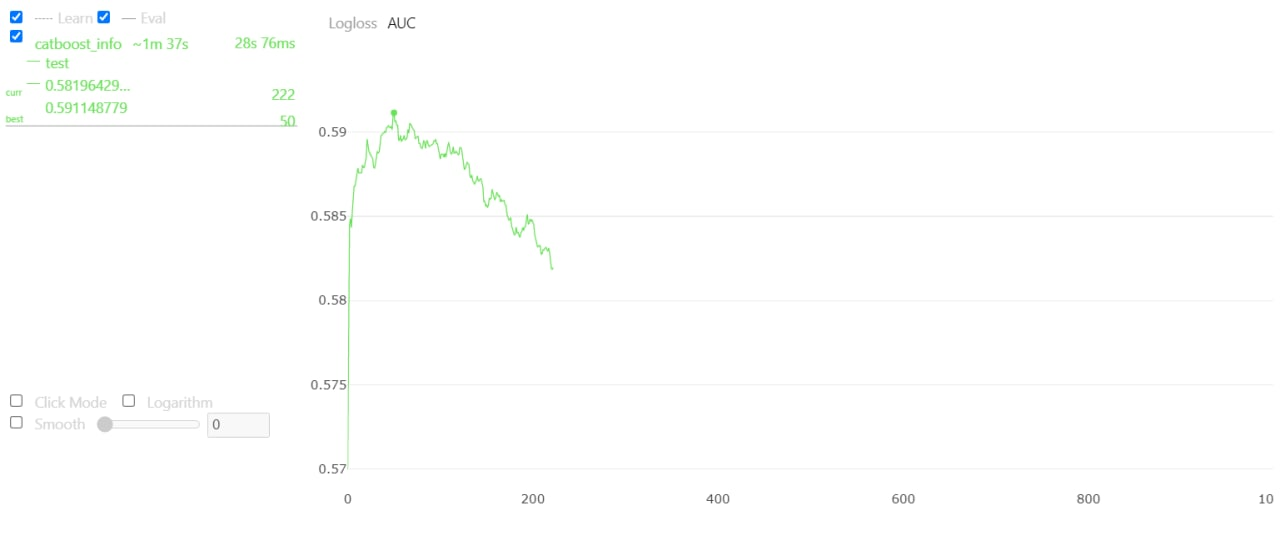

Based on the result above, we can conclude that for the default values of model parameters, AUC achives the maximum for the test set at the 50th iteration, and starts to fall after that. To tune parameters values catboost randomized_search() method will be used

# Tuning parameters values <br>

Round 1

In [36]:
model = CatBoostClassifier(cat_features=cat_features_index,
                           eval_metric='AUC:hints=skip_train~false',
                           custom_metric='AUC:hints=skip_train~false', 
                           early_stopping_rounds=250,
                           random_state=42,
                           verbose=False)

In [39]:
distr = {
    'iterations': randint(50, 1000),
    'depth': [1, 4, 6, 8, 10],
    'l2_leaf_reg': [0, 5, 10, 15],
    'random_strength': [0, 3, 7, 10],
    'bagging_temperature': [0, 1, 3, 5]
}

clf = RandomizedSearchCV(model, distr, scoring='roc_auc',
                         cv=5, n_iter=200,
                         random_state=42, verbose=2)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END bagging_temperature=3, depth=8, iterations=910, l2_leaf_reg=10, random_strength=7; total time= 1.1min
[CV] END bagging_temperature=3, depth=8, iterations=910, l2_leaf_reg=10, random_strength=7; total time=  59.0s
[CV] END bagging_temperature=3, depth=8, iterations=910, l2_leaf_reg=10, random_strength=7; total time=  59.3s
[CV] END bagging_temperature=3, depth=8, iterations=910, l2_leaf_reg=10, random_strength=7; total time= 1.0min
[CV] END bagging_temperature=3, depth=8, iterations=910, l2_leaf_reg=10, random_strength=7; total time=  57.1s
[CV] END bagging_temperature=5, depth=10, iterations=70, l2_leaf_reg=10, random_strength=3; total time=   6.8s
[CV] END bagging_temperature=5, depth=10, iterations=70, l2_leaf_reg=10, random_strength=3; total time=   6.2s
[CV] END bagging_temperature=5, depth=10, iterations=70, l2_leaf_reg=10, random_strength=3; total time=   5.7s
[CV] END bagging_temperature=5, depth=10, iterat

KeyboardInterrupt: ignored

In [ ]:
search_results['params']

{'bagging_temperature': 0,
 'random_strength': 3,
 'depth': 6,
 'l2_leaf_reg': 5,
 'learning_rate': 0.18330239291193462,
 'iterations': 773.0}